<div>
<center>
    <img src="https://datascientest.fr/train/assets/logo_datascientest.png", style="height:150px">
</center> 
</div>

<hr style="border-width:2px;border-color:##75DFC1">
<br>
<center> <h1> Segmentation de régions nuageuses </h1> </center> <br><br>
<center> <h2> Parties 3 - Segmentation </h2> </center> <br><br>
<hr style="border-width:2px;border-color:##75DFC1">

<div class="panel" style="border-width:2px;border-color:##75DFC1"> 
    <div class="panel-body">
<h3> Contexte du sujet </h3>
<p>Il s’agit d’analyser et d’identifier dans chaque image satellite les régions qui contiennent une formation nuageuse particulière (poisson, fleur, gravier, sucre). Ces segmentations aident à la projection climatique en permettant de démystifier une des variables importantes du climat.</p>
        
<h3>Data</h3>
<p>Les données sont des images satellites labellisées, un set de donnée test non labellisé est disponible.<br>
[Données Kaggle]<span style="color:#660099;">
    <a href="https://www.kaggle.com/c/understanding_cloud_organization/">
        https://www.kaggle.com/c/understanding_cloud_organization/</a></p> 
        </div>       
</div>

### Groupe
> * Cathy Baynaud-Samson,
> * Yann Bernery
> * José Castro
> * Ludovic Changeon

## **1 - Import des librairies**

La librairie du projet Nebula est chargée du master Github, avant l'import général.

In [7]:
# Création de répertoires pour stocker le Git, les librairies et checkpoints
!mkdir nebulaTemp -p
!mkdir packages -p

# Copie des sources des librairies projet depuis le Github
!git clone https://github.com/DataScientest/nebula/ ./nebulaTemp --dissociate

# Répartition des différentes ressources dans les répertoires
!cp ./nebulaTemp/packages/* ./packages

# Suppression de la copie du repository source
!rm nebulaTemp -r

Cloning into './nebulaTemp'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 267 (delta 111), reused 120 (delta 69), pack-reused 73
Receiving objects: 100% (267/267), 26.14 MiB | 5.27 MiB/s, done.
Resolving deltas: 100% (136/136), done.


Initialisation de la variable d'environnement SM_FRAMEWORK, nécessaire à l'import du package segmentation_models.

In [8]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [9]:
pip install segmentation_models

     |████████████████████████████████| 51kB 7.6MB/s 


Import des librairies

In [10]:
# Import des librairies du projet
import packages

# Librairies génériques
import os, glob
from shutil import copyfile, unpack_archive
import zipfile
import random
import numpy as np
import pandas as pd
from numpy import argmax
from copy import deepcopy
from numpy.random import seed
import requests

# Librairies images/graphiques
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import PIL
from   PIL import Image
import cv2
from matplotlib import patches
import seaborn as sns

# Interface library machine learning
import tensorflow as tf
import multiprocessing
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model, load_model
from albumentations import Compose, VerticalFlip, HorizontalFlip, Rotate, RandomGamma 
from tensorflow.keras.optimizers import Nadam, RMSprop
from tensorflow.keras import callbacks
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Scikit Learn
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops

Installation et import du package segmentation_models

In [11]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


## **2 - Import des données**

Préalables :
* Google Drive est connecté sous "/content/drive/MyDrve"
* Le zip du dataset est disponible sur le Google Drive

Copie puis décompression du zip du dataset (environ 6 minutes)<br>

In [14]:
packages.copy_data_from_drive()

True

Définition des répertoires :

In [15]:
repTest  = 'test_images/'
repTrain = 'train_images/'

Chargement du fichier train.csv :

In [16]:
train = packages.load_train()
train.head(5)

Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...

## **3 - Pre-traitement du dataset**

On définit tout d'abord quelques constantes utilisées tout au long de ce notebook.

*Remarques sur la taille des images* :<br>
Les images ont une taille d'origine de 1400 X 2100 pixels. Nous ne pouvons conserver cette taille à l'entrée de nos modèles, sous peine de manquer de mémoire. Nous allons réduire la dimension de nos images a 320 X 480. Cette taille a l'avantage de converser le ratio largeur / longueur de l'image, par ailleurs la largeur comme la longueur sont des multiples de 32.<br>
La taille de soumission (350 X 525) est la taille des masques attendus par Kaggle, l'opération de réduction sera opérée lors de la préparation du fichier final de soumission.


In [17]:
target_size = (320, 480)                #Taille à laquelle les images seront redimensionnées a l'entrée du modele
origin_size = (1400, 2100)              #Taille d'orgine des images
submission_mask_size = (350, 525)       #Taille à laquelle les masques sont attendus par Kaggle (cf. partie Evaluation du projet sur Kaggle) 
nb_canaux = 3
num_cores = multiprocessing.cpu_count()
couleurs=[(0,0,255), (255,0,0), (0,255,0), (255,255,0)]

On isole les labels et le nom des images en prenant soin de laisser les encodage RLE nuls.

In [18]:
train = packages.label_parsing(train, drop_na=False)
train.head(5)

EncodedPixels        image   label
0  264918 937 266318 937 267718 937 269118 937 27...  0011165.jpg    Fish
1  1355565 1002 1356965 1002 1358365 1002 1359765...  0011165.jpg  Flower
2                                                NaN  0011165.jpg  Gravel
3                                                NaN  0011165.jpg   Sugar
4  233813 878 235213 878 236613 878 238010 881 23...  002be4f.jpg    Fish

Enfin, nous allons agréger les encodages RLE par image puis sur cette base initialiser un dictionnaire qui sera le principal vecteur de recherche des générateurs d'images lors de l'apprentissage des modèles.

In [19]:
#Depuis le dataframe précédent on détermine la liste des classes ...
formations_nuageuses = train['label'].unique()

# ... ainsi que leur nombre
nb_classes = len(formations_nuageuses)

#On agrège les codes RLE par image pour les présenter en ligne
train_transformed = pd.concat([train.set_index(['image']).groupby('label')['EncodedPixels'].get_group(key) for key in formations_nuageuses],axis=1)
train_transformed.columns = formations_nuageuses
train_transformed.reset_index(inplace=True)

#Dernière étape du pré-traitement: on construit un dictionnaire à partir du dataframe précédent
#Ceci va nous permettre d'accélérer l'accès aux codes RLE depuis l'image lors de la phase d'apprentissage du modèle 
index_classes = {image:rle for image, rle in zip(train_transformed['image'], train_transformed.iloc[:, 1:].values)}


train_transformed.head(3)

image  ...                                              Sugar
0  0011165.jpg  ...                                                NaN
1  002be4f.jpg  ...  67495 350 68895 350 70295 350 71695 350 73095 ...
2  0031ae9.jpg  ...  658170 388 659570 388 660970 388 662370 388 66...

[3 rows x 5 columns]

## **4 - Générateur et traitement des images**

Nous avons opté pour la création d'un générateur personnalisé hérité de la classe Sequence. Ce choix est motivé par la possibilité offerte d'utiliser les albumentations en lieu et place des augmentations natives de tensorflow, et d'autre part, par la simplicité d'ajout de retraitement d'images.
Le générateur offre la possibilité d'appliquer aux images, lors de l'apprentissage, les augmentations ci-dessous :

- Symétrie horizontale
- Symétrie verticale
- Rotation dans la limite de 10 degrés
- Correction gamma

Les corrections gamma ont été choisies pour atténuer les stries solaires constatées sur certaines images.

Par ailleurs il est possible d'activer deux options de pré-traitement des images :
- le Test Time Augmentation (TTA) : cela concerne uniquement les prédictions faites sur la base d'un générateur. L'option consiste à appliquer une symétrie horizontale systématique a l'image. Il conviendra alors d'inverser la transformation sur les valeurs prédites puis d'effectuer une moyenne avec les valeurs issues d'une prédiction sans TTA.

- la réduction de bruit : cette option va venir appliquer un masque aux images afin d'éliminer les pixels inférieurs a une certaine valeur de blanc. Il pourra être intéressant de pré-entrainer un modèle sur un nombre d'epochs limité afin de le faire travailler sur la forme des nuages, avant un apprentissage complet sans réduction de bruit. Ci-dessous l'illustration d'un masque de réduction de bruit (à gauche l'image d'origine, a droite l'image retraitée destinée a pratiquer un pré-apprentissage).


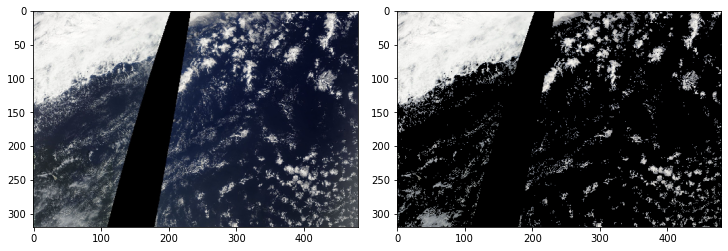

In [20]:
# Chargement d'une image de test
img = load_img(os.path.join(repTrain, '7405a00.jpg'), target_size=target_size)
im3 = np.array(img)
image_gray = cv2.cvtColor(im3, cv2.COLOR_RGB2GRAY)
# Filtrage
(thresh, blackAndWhiteImage) = cv2.threshold(image_gray, 110, 255, cv2.THRESH_BINARY)
img2 = cv2.bitwise_and(im3, im3, mask=blackAndWhiteImage)
# Affichage
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 20), constrained_layout=True)
ax[0].imshow(img) 
ax[1].imshow(img2) 
plt.show()

Définition du générateur :

In [21]:
class MultiGenerator(tf.keras.utils.Sequence):

    def __init__(self, 
                 images_set, 
                 index_classes=None, 
                 base_path=repTrain,
                 batch_size=32, 
                 image_size=origin_size, 
                 nb_canaux=3, 
                 reshape=None,
                 augment=False, 
                 nb_classes=4, 
                 random_state=123, 
                 shuffle=True,
                 tta_mode=False,
                 preproc=[]):

        self.images_set = images_set         #Liste d'images à générer 
        self.index_classes = index_classes   #Dictionnaire image/codes RLE
        self.base_path = base_path           #Répertoire source                    
        self.image_size = image_size         #Taille d'origine des images
        self.reshape = reshape               #Taille cible des images         
        self.batch_size = batch_size         #Taille du batch
        self.nb_canaux = nb_canaux           #Nombre de canaux (3 ou 1)
        self.augment = augment               #Augmentation à appliquer (O/N)
        self.nb_classes = nb_classes         #Nombre de classes cibles
        self.shuffle = shuffle               #Mélange aleatoire (O/N) 
        self.random_state = random_state     #Graine

        self.tta_mode = tta_mode             #Test Time Augment. à appliquer (O/N)
        #Info : Le TTA consiste ici en un flip horizontal de l'image

        self.preproc = preproc               #Pré-processing des images
        #Info : Le pré-processing peut accepter les valeurs suivantes :
        # 'fnoise' : réduction du bruit par application d'un masque
        #Les actions de pré-processing peuvent être cumulées

        #Le mode TTA n'est disponible que lors d'une prédiction 
        if self.index_classes is not None:
            self.tta_mode = False

        #Le mode TTA et l'augmentation aléatoire sont incompatibles    
        if self.tta_mode:
            self.augment = False
        
        self.on_epoch_end()
        np.random.seed(self.random_state)

    ##  __len__
    #  -------------------
    #  On détermine le nombre de lots par epoch
    def __len__(self):
        return int(np.floor(len(self.images_set) / self.batch_size))

    #Méthode : Constitution d'un lot
    def __getitem__(self, index):

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        images_set_batch = [self.images_set[k] for k in indexes]
        
        X = self.__generate_X(images_set_batch)
        
        #Mode prédiction : l'index des classes n'a pas été spécifié
        if self.index_classes == None:                    
            return X  

        #Mode apprentissage : l'index des classes a bien été spécifié
        else:                                             
            y = self.__generate_y(images_set_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            
            return X, y

        
    def on_epoch_end(self):
        'Reindexation des lots'
        self.indexes = np.arange(len(self.images_set))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, images_set_batch):
        'Generation des features'
        # Initialisation des features
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.image_size, self.nb_canaux))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.nb_canaux))
        
        # Génération des données depuis les images
        for i, image_name in enumerate(images_set_batch):
            img_path = f"{self.base_path}/{image_name}"
            img = self.__load_rgb(img_path)
            
            #L'image est redimmensionnée si besoin
            if self.reshape is not None:
                img = packages.np_transposition(img, self.reshape)
            
            #TTA active : on réalise une symétrie horizontale de l'image
            if self.tta_mode:
                img = np.flip(img, axis=1)

            X[i,] = img

        return X
    
    def __generate_y(self, images_set_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.image_size, self.nb_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.nb_classes), dtype=int)
        
        for i, image_name in enumerate(images_set_batch):
            rles = self.index_classes[image_name]

            if self.reshape is not None:
                masks = packages.list_rleToMask(rles, input_shape=self.image_size, reshape=self.reshape)
            else:
                masks = packages.list_rleToMask(rles, input_shape=self.image_size)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if 'fnoise' in self.preproc:
            image_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            (thresh, blackAndWhiteImage) = cv2.threshold(image_gray, 110, 255, cv2.THRESH_BINARY)
            img = cv2.bitwise_and(img, img, mask=blackAndWhiteImage)

        img = img.astype(np.float32) / 255.

        return img
    
    ## albumentationApply 
    #  -------------------
    #  On applique à l'image et au masque passé en paramètre
    #  une série de transformations. 

    def __albumentationApply(self, img, masks):
        transformations_pipline = Compose([
            HorizontalFlip(),         #Symétrie horizontale
            VerticalFlip(),           #Symétrie verticale
            Rotate(limit=10),         #Rotation dans la limite de 10 degrés
            RandomGamma()             #Correction gamma
        ])
        
        transformations = transformations_pipline(image=img, mask=masks)
        augmented_img   = transformations['image']
        augmented_masks = transformations['mask']
        
        return augmented_img, augmented_masks
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__albumentationApply(
                img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch

## **5 - Implémentation d'un modèle de segmentation**

Lors des essais préliminaires, les modèles personnels construits "from scratch" ne dépassant pas une précision de 0.55, il a été décidé de faire appel à des modèles plus conséquents.

### **5.1 - Stratégie et architecture**

Nous allons implémenter deux modèles. Ces deux modèles seront entrainés sur le même jeu de données, puis leurs prédictions respectives feront l'objet d'une moyenne pondérée. Afin de maximiser la précision de l'ensemble nous choisissons deux modèles à l'architecture éloignée (donc moins corrélée) l'une de l'autre.

Nous avons opté pour un premier modèle basé sur une architecture "Unet" et un backbone "resnet 18". Le second modèle s'appuie quant à lui sur une architecture "Linknet" et un backbone "efficient Net B1".<br>
Etant limité en mémoire, ces deux architectures présentent l'avantage de compter un nombre relativement restreint de paramètres.


In [22]:
model1 = packages.buildSegmentationModel1(sm, nb_classes, target_size, nb_canaux)

44924928/44920640 [==============================] - 2s 0us/step


In [23]:
model2 = packages.buildSegmentationModel2(sm, nb_classes, target_size, nb_canaux)

27164672/27164032 [==============================] - 124s 5us/step


In [ ]:
#model1.summary()

In [ ]:
#model2.summary()

### **5.2 - Métriques et pertes**

Les fonctions présentées dans ce chapitre sont utilisées via la librairie projet "packages".  
Les codes simplifiés présentés ci-dessous se veulent pédagogiques afin de permettre au lecteur de disposer du minimum d'information nécessaire à une bonne compréhension du notebook.

#### **5.2.1 - Métriques**

Deux métriques spécifiques aux problématiques de "computer vision" sont définies :  
* Intersection over union (IoU) ou indice de Jaccard (<a href = "https://fr.wikipedia.org/wiki/Indice_et_distance_de_Jaccard">IoU</a> sur Wikipedia)
* Coefficient de Dice (<a href="https://fr.wikipedia.org/wiki/Indice_de_S%C3%B8rensen-Dice">Indice de Dice</a> sur Wikipedia).

Ces deux métriques partent du même principe : comparer l'intersection et l'union de deux ensembles afin de quantifier leur corrélation :  
* $IoU={|A\cap B| \over |A\cup B|}$
* $Dice={2|A\cap B| \over |A| + |B|}$

Codage de la métrique iou :

In [ ]:
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

Codage de la métrique de Dice :

In [ ]:
def dice(y_true, y_pred , classWeights = np.ones(4)):
  inter = K.log(1. + y_true * y_pred) / K.log(2.)
  num = K.mean(K.sum(inter,(2,1)),0)
  denom = K.mean(K.sum(y_true,(2,1)) + K.sum(y_pred,(2,1)),0)
  m= (2.*K.sum(num * classWeights) + K.epsilon()) / (K.sum(denom * classWeights) + K.epsilon())
  return m

Notes :
* Le codage de la métrique de Dice a été réalisé pour permettre d'utiliser la fonction en tant que perte pour l'entraînement des modèles.  
* Les métriques ci-dessus sont définies pour des tenseurs de rang 4. Le codage dans la librairie projet "packages" intègre les rangs entre 1 et 4 pour la métrique de Dice. Ceci permet d'utiliser cette métrique sur tous types de tenseurs (1 : vecteurs, 2 : images individuelles, 3 : lots de quatre masques détectés pour une image, 4 : lots de masques détectés pour un lot d'images).
* Afin de disposer d'un levier supplémentaire pour surveiller l'entraînement suivant la métrique de Dice, une pondération a été ajoutée sous forme d'un vecteur de quatre poids (classWeights) se référant aux quatre classes de notre problématique de segmentation.

#### **5.2.2 - Pertes**

Deux pertes sont utilisées :
* Binary_crossentropy qui fait partie des pertes pré-codées dans keras et qui fournit de très bons résultats.
* DiceLoss : afin de tenter de changer de paradigme, une fonction de perte a été codée à partir du coefficient de Dice défini au chapitre métriques, ci-dessus.

La perte Binary Crossentropy est classique, on ne reviendra pas sur sa définition.  
La perte DiceLoss est quant à elle définie à partir du coefficient de Dice (DiceCoeff) telle que :  
<p align="center">$DiceLoss(T_1, T_2) = 1 - DiceCoeff(T_1, T_2)$</p>   
<p>Avec : $T_1$ et $T_2$ : deux tenseurs Tensorflow de rangs 4, à valeurs réelles comprises entre 0 et 1.</p>

### **5.3 - Compilation et apprentissage**

**Fonctions de compilation et d'ajustement**

Les fonctions de base comme les fonctions de compilation et d'ajustement ont fait l'objet de l'implémentation d'un wrapper destiné à surcharger les modèles de classification (phase 2) et de segmentation (phase 3).

**Fonction callbacks**

Trois callbacks ont été définies dans les packages, la sauvegarde des poids du meilleur modèle en cours d'entraînement, la réduction sur palier du taux d'apprentissage de l'optimizer et enfin la fin prématurée de l'apprentissage si la perte stagne en validation. 

### **5.4 - Apprentissage des modèles**

**Métriques communes :**

Nous allons monitorer les 2 modèles sur des métriques identiques. (cf point "Métriques et pertes").

In [24]:
#Nous definissons pour les 2 modeles un pool de metriques communes
classWeights = [1., 1., 1., 1.]
dice_metrics = packages.diceMetric(classWeights=classWeights)
metrics_pool = [packages.iou_coef, dice_metrics]

**Réservation d'un set de test :**

Afin de pouvoir établir des prédictions et des évaluations sur des images inconnues des modèles, et pour lesquelles nous connaissons les labels, nous mettons de côté 224 images du set d'apprentissage.

In [25]:
test_size = 224
data_collector, test_collector = packages.splitValid(train_transformed['image'], test_size=test_size)

**Ajustement du modèle 1 :**

Nous allons pour le premier modèle opérer un pré-apprentissage sur un nombre d'epochs réduit. Ce pré-apprentissage va s'effectuer non pas sur les images d'origine mais sur les images résultantes de l'application d'un masque destiné à filtrer les bruits. Notre objectif est de faciliter pour notre modèle la reconnaissance des formes des nuages et ainsi d'initialiser les poids pour l'apprentissage définitif.

Nous ne spécifions pour ce pré-apprentissage aucun callback.
L'optimizer retenu pour ce premier modèle est le Nadam. La fonction perte est un binary cross entropy (bce).


In [ ]:
#Par défaut le preprocessing de reduction de bruit est désactivé
m1pre_fnoise = False

In [ ]:
m1pre_fnoise = True

# Hyperparamètres
#-------------------------------
batchSize = 32
epochs         = 5            #le pré-apprentissage est lancé sur 5 epochs     
learning_rate  = 0.0005       #Taux d'apprentissage de l'optimizer
checkpointName = ''           #Nous ne sauvegardons pas les poids sur cette itération

# Générateurs
#-------------------------------
train_imgs, val_imgs = packages.splitValid(data_collector)
train_imgs = train_imgs.tolist()
val_imgs = val_imgs.tolist()

train_generator = MultiGenerator(train_imgs,
                                index_classes=index_classes,
                                batch_size=batchSize,
                                reshape=target_size,
                                augment=True,
                                nb_canaux=nb_canaux,
                                nb_classes=nb_classes,
                                preproc=['fnoise'])

val_generator = MultiGenerator(val_imgs,
                                index_classes=index_classes,
                                batch_size=batchSize, 
                                reshape=target_size,
                                augment=False,
                                nb_canaux=nb_canaux,
                                nb_classes=nb_classes,
                                preproc=['fnoise'])

model1 = packages.buildSegmentationModel1(sm, nb_classes, target_size, nb_canaux)
m1Wrapper = packages.NebulaWrapper(model1, autoInit=False)

optimizer = Nadam(learning_rate=learning_rate)
m1Wrapper.compile(optimizer, metrics=metrics_pool)
history1p = m1Wrapper.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks = [], class_weight=None)


Epoch 1/5
133/133 [==============================] - 459s 3s/step - loss: 0.3839 - iou_coef: 0.1947 - diceM: 0.4421 - val_loss: 0.6295 - val_iou_coef: 0.1158 - val_diceM: 0.2190
Epoch 2/5
133/133 [==============================] - 442s 3s/step - loss: 0.2965 - iou_coef: 0.2406 - diceM: 0.4655 - val_loss: 0.5738 - val_iou_coef: 0.0504 - val_diceM: 0.1073
Epoch 3/5
133/133 [==============================] - 440s 3s/step - loss: 0.2845 - iou_coef: 0.2596 - diceM: 0.5059 - val_loss: 0.6012 - val_iou_coef: 0.0879 - val_diceM: 0.1652
Epoch 4/5
133/133 [==============================] - 445s 3s/step - loss: 0.2781 - iou_coef: 0.2709 - diceM: 0.4895 - val_loss: 0.9106 - val_iou_coef: 0.0038 - val_diceM: 0.0129
Epoch 5/5
133/133 [==============================] - 441s 3s/step - loss: 0.2738 - iou_coef: 0.2771 - diceM: 0.5113 - val_loss: 0.7837 - val_iou_coef: 0.0240 - val_diceM: 0.0551


Une fois le pré-apprentissage terminé, nous lançons l'apprentissage définitif de notre premier modèle.

In [ ]:

# Hyperparametres
#-------------------------------
batchSize = 32
epochs         = 40                 #Nombre max d'epochs
learning_rate  = 0.001              #Taux d'apprentissage de départ
checkpointName = 'resnet18'         #Nom racine des fichiers de sauvegarde

reducePatience = 3                   #nb d'epochs max après lequel on réduit le taux d'apprentissage
                                     #si le val_loss ne s'améliore pas

reduceFactor   = 0.05                #facteur de réduction du taux d'apprentissage

earlyStopPatience = 7                #nb d'epochs max avant lequel on arrête l'apprentissage
                                     #si le val_loss ne s'améliore pas

# Générateurs
#-------------------------------
train_imgs, val_imgs = packages.splitValid(data_collector)
train_imgs = train_imgs.tolist()
val_imgs = val_imgs.tolist()

train_generator = MultiGenerator(train_imgs,
                                index_classes=index_classes,
                                batch_size=batchSize,
                                reshape=target_size,
                                augment=True,
                                nb_canaux=nb_canaux,
                                nb_classes=nb_classes)

val_generator = MultiGenerator(val_imgs,
                                index_classes=index_classes,
                                batch_size=batchSize, 
                                reshape=target_size,
                                augment=False,
                                nb_canaux=nb_canaux,
                                nb_classes=nb_classes)

if not m1pre_fnoise:
    model1 = packages.buildSegmentationModel1(sm, nb_classes, target_size, nb_canaux)
    m1Wrapper = packages.NebulaWrapper(model1, autoInit=False)
    optimizer = Nadam(learning_rate=learning_rate)
    m1Wrapper.compile(optimizer, metrics=metrics_pool)

# Définition des callbacks à appliquer pendant l'apprentissage
lstCallbacks = [packages.cb_earlyStopping(patience = earlyStopPatience),
                packages.cb_modelCheckPoint(checkpointName),  
                packages.cb_reduceLr(patience =reducePatience, factor = reduceFactor)]

history1 = m1Wrapper.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks = lstCallbacks, class_weight=None)

Epoch 1/40
133/133 [==============================] - 444s 3s/step - loss: 0.2706 - iou_coef: 0.2833 - diceM: 0.5099 - val_loss: 1.1241 - val_iou_coef: 0.1226 - val_diceM: 0.1993
Epoch 2/40
133/133 [==============================] - 433s 3s/step - loss: 0.2647 - iou_coef: 0.2918 - diceM: 0.5319 - val_loss: 1.4716 - val_iou_coef: 0.1259 - val_diceM: 0.1993
Epoch 3/40
133/133 [==============================] - 434s 3s/step - loss: 0.2612 - iou_coef: 0.2987 - diceM: 0.5417 - val_loss: 0.6951 - val_iou_coef: 0.1779 - val_diceM: 0.3171
Epoch 4/40
133/133 [==============================] - 440s 3s/step - loss: 0.2582 - iou_coef: 0.3032 - diceM: 0.5296 - val_loss: 0.3824 - val_iou_coef: 0.2623 - val_diceM: 0.4539
Epoch 5/40
133/133 [==============================] - 441s 3s/step - loss: 0.2546 - iou_coef: 0.3099 - diceM: 0.5474 - val_loss: 0.3312 - val_iou_coef: 0.2999 - val_diceM: 0.5345
Epoch 6/40
133/133 [==============================] - 441s 3s/step - loss: 0.2515 - iou_coef: 0.3149 - di

**Ajustement du modèle 2 :**

Le second modèle ne fait l'objet que d'un cycle d'apprentissage. 

L'optimizer retenu est RMSProp, la fonction perte est un Dice personnalisé, dont les détails sont donnés dans la partie "Métriques et pertes" de ce notebook.


In [ ]:
# Hyperparamètres
#-------------------------------
batchSize = 18
epochs         = 30                  #av 30Nombre max d'epochs
learning_rate  = 0.001               #Taux d'apprentissage de départ
checkpointName = 'efficientnetb1'    #Nom racine des fichiers de sauvegarde

reducePatience = 3                   #nb d'epochs max après lequel on réduit le taux d'apprentissage
                                     #si le val_loss ne s'améliore pas

reduceFactor   = 0.05                #av 0.08 facteur de réduction du taux d'apprentissage

earlyStopPatience = 6                #av 6 nb d'epochs max après lequel on arrête l'apprentissage
                                     #si le val_loss ne s'améliore pas

# Générateurs
#-------------------------------
train_imgs, val_imgs = packages.splitValid(data_collector)
train_imgs = train_imgs.tolist()
val_imgs = val_imgs.tolist()

train_generator = MultiGenerator(train_imgs,
                                index_classes=index_classes,
                                batch_size=batchSize,
                                reshape=target_size,
                                augment=True,
                                nb_canaux=nb_canaux,
                                nb_classes=nb_classes)

val_generator = MultiGenerator(val_imgs,
                                index_classes=index_classes,
                                batch_size=batchSize, 
                                reshape=target_size,
                                augment=False,
                                nb_canaux=nb_canaux,
                                nb_classes=nb_classes)



# Définition des callbacks à appliquer pendant l'apprentissage
lstCallbacks = [packages.cb_earlyStopping(patience = earlyStopPatience),
                packages.cb_modelCheckPoint(checkpointName),  
                packages.cb_reduceLr(patience =reducePatience, factor = reduceFactor)]

model2 = packages.buildSegmentationModel2(sm, nb_classes, target_size, nb_canaux)
m2Wrapper = packages.NebulaWrapper(model2, autoInit=False)

classWeights = [1., 1., 1., 1.]
m2_loss    = packages.diceLoss(name='diceL', classWeights=classWeights)
optimizer = RMSprop(learning_rate=learning_rate)

m2Wrapper.compile(optimizer, loss=[m2_loss], metrics=metrics_pool)
history2 = m2Wrapper.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks = lstCallbacks, class_weight=None)


Epoch 1/30
236/236 [==============================] - 489s 2s/step - loss: 0.5097 - iou_coef: 0.3133 - diceM: 0.5221 - val_loss: 0.5735 - val_iou_coef: 0.2762 - val_diceM: 0.4129
Epoch 2/30
236/236 [==============================] - 453s 2s/step - loss: 0.4338 - iou_coef: 0.3916 - diceM: 0.6013 - val_loss: 0.4889 - val_iou_coef: 0.3514 - val_diceM: 0.5059
Epoch 3/30
236/236 [==============================] - 444s 2s/step - loss: 0.4252 - iou_coef: 0.4000 - diceM: 0.6030 - val_loss: 0.4247 - val_iou_coef: 0.4046 - val_diceM: 0.6664
Epoch 4/30
236/236 [==============================] - 436s 2s/step - loss: 0.4168 - iou_coef: 0.4088 - diceM: 0.6051 - val_loss: 0.4254 - val_iou_coef: 0.4028 - val_diceM: 0.6672
Epoch 5/30
236/236 [==============================] - 442s 2s/step - loss: 0.4087 - iou_coef: 0.4149 - diceM: 0.5365 - val_loss: 0.4081 - val_iou_coef: 0.4181 - val_diceM: 0.6791
Epoch 6/30
236/236 [==============================] - 449s 2s/step - loss: 0.4025 - iou_coef: 0.4202 - di

### **5.5 - Chargement des modèles**

#### **5.5.1 - Import des fichiers poids**

Les poids des modèles sont téléchargeables depuis un drive, dont les liens sont prédéfinis ci-dessous. Il faut au préalable installer et importer la librairie gdown.

Les poids sont également, si besoin, disponibles sous la forme d'un dataset hébergé sur le serveur Kaggle. Ils sont téléchargeables manuellement a l'adresse : <a href="https://www.kaggle.com/dataset/a4aa98fe1f1daf12d45c66cea8f6790a437767ce0260adbf64b51afafa462189">Nebula Segmentation Weight</a> ou de manière automatique via le code indiqué plus bas. Il faut noter que dans ce dernier cas, d'une part un token d'authentification sera nécessaire et, d'autre part, il sera nécessaire d'installer l'API Kaggle.

***Import depuis Google Drive***

In [1]:
pip install gdown

In [2]:
import gdown

In [4]:
def getWeightFromLink(url, output_file):
    gdown.download(url, output_file, quiet=False)

In [6]:
getWeightFromLink('https://drive.google.com/uc?id=1xUloap3iXApjf0Gz4qefWgnMpbLDpdqS', 'resnet18n.index')
getWeightFromLink('https://drive.google.com/uc?id=1JRrKMxyQ3R4liPbhg0pp0AAWiUruzjyr', 'resnet18n.data-00000-of-00001')
getWeightFromLink('https://drive.google.com/uc?id=1DzUDrmMHZ-Z69P2k5gmB3l6ls_lFa4k4', 'efficientnetb1n.index')
getWeightFromLink('https://drive.google.com/uc?id=14bk-9aDeQ8RbQGI1CN8UpuHTLe2NdQEb', 'efficientnetb1n.data-00000-of-00001')

Downloading...
From: https://drive.google.com/uc?id=1xUloap3iXApjf0Gz4qefWgnMpbLDpdqS
To: /content/resnet18n.index
100%|██████████| 23.1k/23.1k [00:00<00:00, 13.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JRrKMxyQ3R4liPbhg0pp0AAWiUruzjyr
To: /content/resnet18n.data-00000-of-00001
172MB [00:02, 79.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DzUDrmMHZ-Z69P2k5gmB3l6ls_lFa4k4
To: /content/efficientnetb1n.index
100%|██████████| 63.3k/63.3k [00:00<00:00, 18.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=14bk-9aDeQ8RbQGI1CN8UpuHTLe2NdQEb
To: /content/efficientnetb1n.data-00000-of-00001
68.8MB [00:00, 79.7MB/s]


***Import depuis Kaggle***

*Veuillez décommenter et executer les lignes suivantes si l'import depuis Google Drive a échoué.*

In [43]:
#!pip install -q kaggle
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!ls ~/.kaggle
#!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [47]:
#!kaggle datasets download -d ludovicchangeon/nebulasegmentationweights
#unpack_archive('nebulasegmentationweights.zip')

 98% 207M/212M [00:00<00:00, 222MB/s]
100% 212M/212M [00:01<00:00, 219MB/s]


#### **5.5.2 - Chargement des modèles**

**Chargement du modèle 1 :**


In [26]:
chkpt_segm1 = 'resnet18n'
m1Wrapper = packages.NebulaWrapper(model1, autoInit=False)
m1Wrapper.load_weights(chkpt_segm1)

**Chargement du modèle 2 :**

In [28]:
chkpt_segm2 = 'efficientnetb1n'
m2Wrapper = packages.NebulaWrapper(model2, autoInit=False)
m2Wrapper.load_weights(chkpt_segm2)

## **6 - Evaluation de l'apprentissage**

### **6.1 - Accuracy et loss par epoch**

Modèle 1 : Evolution de la perte et de l'accuracy par epoch 

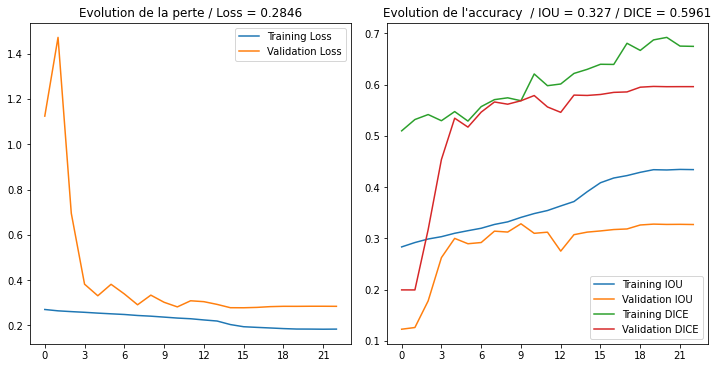

In [ ]:
def plotFitting(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), constrained_layout=True)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
  
    hiou = history.history['iou_coef']
    val_iou = history.history['val_iou_coef']

    hdice = history.history['diceM']
    val_dice = history.history['val_diceM']

    epochs_range = range(len(loss))

    ax[0].plot(epochs_range, loss, label='Training Loss')
    ax[0].plot(epochs_range, val_loss, label='Validation Loss')
    ax[0].legend(loc='upper right')
    ax[0].set_title("Evolution de la perte / Loss = " + str(np.round(val_loss[-1], 4)))  
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    ax[1].plot(epochs_range, hiou, label='Training IOU')
    ax[1].plot(epochs_range, val_iou, label='Validation IOU')
    ax[1].plot(epochs_range, hdice, label='Training DICE')
    ax[1].plot(epochs_range, val_dice, label='Validation DICE')
    ax[1].legend(loc='lower right')
    ax[1].set_title("Evolution de l'accuracy " +
                    " / IOU = " + str(np.round(val_iou[-1], 4)) + 
                    " / DICE = " + str(np.round(val_dice[-1], 4)))  
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

#Modele 1 : évolution de la perte et de l'accuracy
plotFitting(history1)

Modèle 2 : Evolution de la perte et de l'accuracy par epoch 

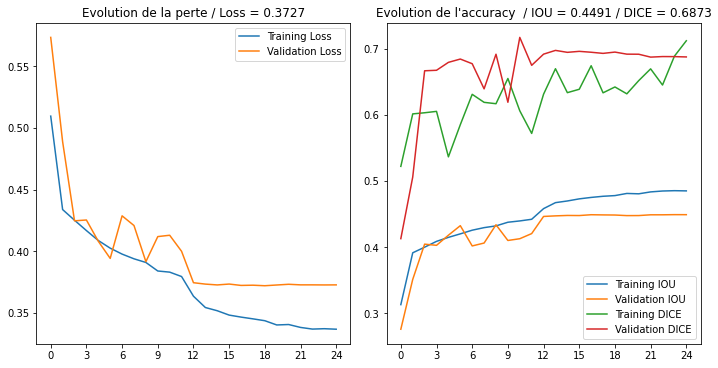

In [ ]:
#Modèle 2 : évolution de la perte et de l'accuracy
plotFitting(history2)

### **6.2 - Précisions par classe**

Nous évaluons à présent, sur la base des 224 images que nous avons mises de côté et via une même métrique, la précision des deux modèles pour chacune des quatre classes de nuages. L'idée ici est uniquement de comparer les deux modèles sur chaque classe et via une métrique identique.

In [ ]:
test_imgs = test_collector.tolist()

In [ ]:
#Sauvegarde des masques d'origine
testS = []
for image in test_imgs:
    lstImg = []
    lstImg.append(image)
    ltMasks = packages.list_rleToMask(index_classes[image], input_shape=origin_size, reshape=target_size)
    lstImg.append(ltMasks)
    testS.append(lstImg)

In [ ]:
#Constitution du générateur temoin
batchSize = 32
test_generator = MultiGenerator(test_imgs,
                              batch_size=batchSize, 
                              reshape=target_size,
                              augment=False,
                              shuffle=False,
                              nb_canaux=nb_canaux,
                              nb_classes=nb_classes)

Nous établissons une estimation de la précision par classe sur la base d'une série restreintes d'images d'une part et selon des seuils d'activation par défaut. Les seuils d'activation plus précis seront établis par classe dans la suite de ce notebook (cf point "Activation des pixels" ci-dessous pour plus de détails).

In [ ]:
maskSeuils   = [.5, .5, .5, .5]

Fonction commune de confusion

In [ ]:
def confusion(trueLabel, predictions):
    #Confusion des masques d'origine et des prédictions du modèle 1
    listAcc = [[] for i in range(len(formations_nuageuses))]

    for i in range(predictions.shape[0]):
        for k in range(len(formations_nuageuses)):
            maskSource = (trueLabel[i][1])[:,:,k]
            (thresh, imgFiltered) = cv2.threshold(predictions[i,:,:,k],
                                              maskSeuils[k], 1,
                                              cv2.THRESH_BINARY)
            listAcc[k].append(packages.dice(maskSource, imgFiltered).numpy())

    #Edition des résultats par classe
    for k in range(4):
        print(formations_nuageuses[k], ' -> ', np.mean(listAcc[k]))

Modèle 1 : Evaluation de la précision par classe de nuages

In [ ]:
#Prédictions des zones nuageuses / modèle 1
prediction_masks1 = model1.predict(test_generator, workers=1, verbose=1)

7/7 [==============================] - 11s 2s/step


In [ ]:
#Confusion des masques d'origine et des prédictions du modèle 1
confusion(testS, prediction_masks1)

Fish  ->  0.55560166
Flower  ->  0.70637494
Gravel  ->  0.5476436
Sugar  ->  0.56499827


Modèle 2 : Evaluation de la précision par classe de nuages

In [ ]:
#Prédictions des zones nuageuses / modèle 2
prediction_masks2 = model2.predict(test_generator, workers=1, verbose=1)

7/7 [==============================] - 12s 1s/step


In [ ]:
#Confusion des masques d'origine et des prédictions du modèle 2
confusion(testS, prediction_masks2)

Fish  ->  0.518205
Flower  ->  0.7330489
Gravel  ->  0.5642716
Sugar  ->  0.5476104


On peut constater que les deux modèles sont très proches, tous deux sont plus aptes à déceler les zones issues de la classe Fleur. Sur ce set en particulier le modèle 1 semble plus performant sur les classes Poisson et Sucre, le modèle 2 sur les classes Fleur et Gravier.

## **7 - Prédictions et soumission Kaggle**

### **7.1 - Prédictions des images de test**

Nous commençons par lister les images à soumettre.

In [29]:
#On prépare un dataframe des images à prédire au format attendu lors de la soumission 
df_sub = pd.read_csv('sample_submission.csv')
df_sub['image'] = df_sub['Image_Label'].apply(lambda x: x.split('_')[0])
    
#... ainsi que la liste des images à prédire
sub_imgs = df_sub['image'].unique().tolist()   

Nous procédons ensuite aux prédictions puis à la formation de l'ensemble. La détermination des prédictions finales va se dérouler en 4 étapes :
- nous effectuons les prédictions sur le lot courant via le premier modèle,
- nous faisons de même avec le second modèle,
- nous déroulons un Test Time Augmentation avec le second modèle,
- nous établissons enfin tout d'abord la moyenne arithmétique des prédictions du modèle 2 (avec et sans TTA) puis une moyenne arithmétique du résultat avec les prédictions du modèle 1.




In [30]:
#Pour éviter les dépassements mémoire, on découpe notre set de soumission en mini-lots 
sub_pred = []
taille_chunk = 50 

currentLot = 0

sub_batch = [sub_imgs[i * taille_chunk:(i + 1) * taille_chunk] for i in range((len(sub_imgs) + taille_chunk - 1) // taille_chunk )]  
indice = True
for lot in sub_batch:

    currentLot += 1
 
    sub_generator  = MultiGenerator(lot,
                              batch_size = 1, 
                              image_size = submission_mask_size,
                              reshape = target_size,
                              base_path = repTest,
                              augment = False,
                              shuffle = False,
                              nb_canaux = nb_canaux,
                              nb_classes = nb_classes)

    tta_generator  = MultiGenerator(lot,
                              batch_size = 1, 
                              image_size = submission_mask_size,
                              reshape = target_size,
                              base_path = repTest,
                              augment = False,
                              shuffle = False,
                              nb_canaux = nb_canaux,
                              nb_classes = nb_classes,
                              tta_mode = True)
    
    print("Lot {} etape 1/4 : Prediction du modele 1".format(currentLot))
    lot_pred1 = model1.predict(sub_generator, workers=1, verbose=1)      #Prédictions du modèle 1

    print("Lot {} etape 2/4 : Prediction du modele 2".format(currentLot))
    lot_pred2_sub = model2.predict(sub_generator, workers=1, verbose=1)      #Prédictions du modèle 2

    print("Lot {} etape 3/4 : Test Time augmentation sur le modele 2".format(currentLot))
    lot_pred2_tta = model2.predict(tta_generator, workers=1, verbose=1)      #Prédictions TTA du modèle 2
    lot_pred2_tta = np.flip(lot_pred2_tta, axis = 2)                               #Inversion de la transformation

    print("Lot {} etape 4/4 : Moyenne de l'ensemble".format(currentLot))
    lot_pred2 = np.average(np.array([lot_pred2_sub, lot_pred2_tta ]), axis=0, weights=[1, 1])
    lot_pred = np.average(np.array([lot_pred1, lot_pred2 ]), axis=0, weights=[1, 1])

    sub_pred.append(lot_pred)

Lot 1 etape 1/4 : Prediction du modele 1
50/50 [==============================] - 19s 56ms/step
Lot 1 etape 2/4 : Prediction du modele 2
50/50 [==============================] - 5s 58ms/step
Lot 1 etape 3/4 : Test Time augmentation sur le modele 2
50/50 [==============================] - 3s 59ms/step
Lot 1 etape 4/4 : Moyenne de l'ensemble
Lot 2 etape 1/4 : Prediction du modele 1
50/50 [==============================] - 3s 59ms/step
Lot 2 etape 2/4 : Prediction du modele 2
50/50 [==============================] - 3s 57ms/step
Lot 2 etape 3/4 : Test Time augmentation sur le modele 2
50/50 [==============================] - 3s 59ms/step
Lot 2 etape 4/4 : Moyenne de l'ensemble
Lot 3 etape 1/4 : Prediction du modele 1
50/50 [==============================] - 3s 56ms/step
Lot 3 etape 2/4 : Prediction du modele 2
50/50 [==============================] - 3s 56ms/step
Lot 3 etape 3/4 : Test Time augmentation sur le modele 2
50/50 [==============================] - 3s 57ms/step
Lot 3 etape 4/4 

### **7.2 - Post-traitement des prédictions**

#### **7.2.1 - Présentation**

Nous avons effectué plusieurs constats lors de la phase 1 :
-	la proportion de blanc des zones nuageuses varie selon la classe,
-	la superficie des zones nuageuses varie également

Ceci nous incite à effectuer deux traitements sur les masques prédits par notre ensemble de modèles :
-	il nous faut faire varier le seuil d'activation des pixels selon la classe. Les classes Gravel et Sugar présentent en effet à des niveaux distincts un pattern plus clairsemé, par conséquent laisser le seuil a 0.5 reviendrait à éliminer un grand nombre de pixels qui pourtant font partie de la zone nuageuse.
-	sur la base de la nouvelle zone couverte, il nous faut éliminer les masques dont la superficie est inférieure a une limite théorique associée à la classe courante


#### **7.2.2 - Activation des pixels**

Ci-dessous une étude sur l'incidence d'un seuil d'activation différent sur une même prédiction.

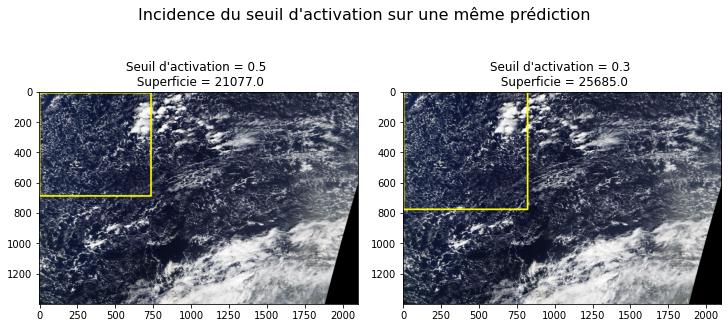

In [ ]:
#Test de seuil de masque sur la première image

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), constrained_layout=True)
fig.suptitle("Incidence du seuil d'activation sur une même prédiction", fontsize=16)

lot = sub_pred[0]
image_indice = 3
pred_masks1 = cv2.threshold(lot[image_indice, :, :, 3], 0.5, 1, cv2.THRESH_BINARY)[1]
im1 = plt.imread(os.path.join(repTest, sub_imgs[0]))

packages.trace_boundingBox(im1, packages.np_transposition(pred_masks1, origin_size), color=(255, 255, 0))
ax1.imshow(im1) 
ax1.set_title("Seuil d'activation = 0.5 \n Superficie = " + str(pred_masks1.sum()))
                
pred_masks2 = cv2.threshold(lot[image_indice, :, :, 3], 0.3, 1, cv2.THRESH_BINARY)[1]
im2 = plt.imread(os.path.join(repTest, sub_imgs[0]))

packages.trace_boundingBox(im2, packages.np_transposition(pred_masks2, origin_size), color=(255, 255, 0))
ax2.imshow(im2)  
ax2.set_title("Seuil d'activation = 0.3 \n Superficie = " + str(pred_masks2.sum()))

plt.show()



A gauche le seuil d'activation est à 0.5, il s'agit du seuil par défaut, qui aurait par exemple était appliqué lors d'une simple conversion de la probabilité du pixel en entier. A droite, le seuil a été placé a 0.3<br>
On constate une incidence dans la superficie de la zone couverte, il s'agit donc d'un paramètre à ne pas négliger.

Nous pouvons rapprocher cette notion de la proportion de blanc déterminée par classe de nuage lors de la phase 1 :
-	Fish : 30 %
-	Flower : 30 %
-	Gravel : 20 %
-	Sugar : 13%

Afin de déterminer les seuils optimaux à appliquer nous allons procéder par échantillonnage du set d'apprentissage en mini-lot de 64 images. Chaque prédiction sera evaluée, par classe, via la métrique DICE sur une trentaine de lots au total. Une moyenne par classe sera au final établie.


**Détermination des seuils optimaux par échantillonnage** 

On définit une fonction qui va venir balayer les seuils d'activation des pixels de chaque classe afin de déterminer le niveau de précision optimal sur l'ensemble de test.

In [ ]:
def thresholdSweep(y_true, y_pred,
                   init = (9, 100, 10),
                   refreshSteps = 5, zoom = 0.1,
                   classWeights = [1.]*4, 
                   verbose = 0):
  '''
    Principe : Recherche d'un seuil de filtrage optimal
    Objectif : Optimiser la moyenne des précisions sur l'ensemble de test.

    Entrées:
      y_pred : y_pred = model.predict(iterTest) => [batch, x, y, masks]
            ex: pour accéder au masque de l'image 0 et de la classe 1 : y_pred[0, :, :, 1]
      y_true : [batch, x, y, masks]
      init : (min, max, step) trois paramètres définissant l'intervalle de recherche initial
      classWeights : [1., 1., 1., 1.] pour la précision complète,
                    annuler les indices des classes dont on ne veut pas
      verbose : 0= pas de sortie texte ; plus verbose est grand, plus grand le nb de sorties (max = 2)
      zoom : facteur appliqué au pas de recherche entre chaque itération
    Sorties :
      x : liste de tous les seuils testés
      y : liste des précisions obtenues pour chacun des seuils
  '''
  # Initialisation des paramètres d'entrée
  x, y = [], []               # Vecteurs de sortie
  min, max, step = init       # Intervalle initial de recherche (0.09, 1.) avec step de balayage initial (0.1)
  etapes = refreshSteps       # Nb de de zooms successifs
  pred = y_pred               # Prédictions de masks sous la forme [batch, tx, ty, mask]
  classWeights = classWeights # Poids sur chacune des classes

  if verbose >0: print(f'Recherche sur l\'intervalle : {init}\n.   Poids de recherche : {classWeights}\n.    Nb étapes : {etapes} / Reduction : {diminution}')
  #
  # Boucle 1 : nombre successifs de zooms de la précision
  for optim in range(etapes):
    if verbose >1 :
      print(f'Step {optim+1} / {etapes}')
      print(f'.  min / max : {min/100:0.4f} / {max/100:0.4f}')
    #
    # Boucle 2 : balayage entre min et max via step
    for s in np.arange(min,max,step):
      listeRes = []
      seuil = [s/100]*4
      #
      # Boucle 3 : on applique la précision sur chacune des images de l'ensemble de test
      for i in range(pred.shape[0]):
        moyenne=[]
        #
        # Boucle 4 : on réalise le calcul pour chacune des classes
        for k in range(4):
          if classWeights[k]==0: # si la classe observée est pondérée à 0, inutile de faire le travail
            moyenne.append(0)
            continue
          srcFiltered = (y_true[i][1])[:,:,k]
          # Filtrage de la prédiction
          (thresh, imgFiltered) = cv2.threshold(pred[i,:,:,k],
                                                seuil[k], 1,
                                                cv2.THRESH_BINARY)
          moyenne.append(packages.dice(srcFiltered,
                              imgFiltered,
                              classWeights = classWeights).numpy()) # calcul de la précision et ajout dans la liste "moyenne"
        listeRes.append(np.sum(moyenne*np.array(classWeights))/np.sum(classWeights)) # calcul de la moyenne de précision par image

      y.append(np.mean(listeRes))
      x.append(s)
    xMax = x[y.index(np.max(y))] # calcul du seuil de précision maxi

    if verbose >1 : print(f'.  acc : {np.max(y):0.5f}')

    # Calcul des paramètres de la prochaine itération
    min = np.max([xMax - step,1])        # on se recentre au niveau de la précision maxi
    max = np.min([xMax + 1.5*step,100-K.epsilon()*10]) # on balaie entre +/- step
    step = step * zoom             # à chaque étape on applique un facteur de zoom constant
  #
  # Affichage des meilleurs paramètres (précision @ seuil)
  if verbose >0 : print(f'Prédiction maxi : {np.max(y):0.5f} @ {x[y.index(np.max(y))]:0.5f}')
  return x,y

On effectue ensuite un échantillonnage du set d'apprentissage (30 lots de 64 images chacun).

In [ ]:
accFit = []
accSeuils = []

for iteration in range(30):
    np.random.seed(seed=None)
    test_size = 64
    data_collector, seuils_collector = packages.splitValid(train_transformed['image'], test_size=test_size, randomState=None)
    
    test_imgs = seuils_collector.tolist()
    testS = []
    for image in test_imgs:
        lstImg = []
        lstImg.append(image)
        ltMasks = packages.list_rleToMask(index_classes[image], input_shape=origin_size, reshape=target_size)
        lstImg.append(ltMasks)
        testS.append(lstImg)

    test_generator = MultiGenerator(test_imgs,
                              batch_size=32, 
                              reshape=target_size,
                              augment=False,
                              shuffle=False,
                              nb_canaux=nb_canaux,
                              nb_classes=nb_classes)  
    
    y_pred = model1.predict(test_generator)
    y_true = testS
    optimSeuil=[] #vecteur de sortie des seuils, dans l'ordre des classes
    optimAcc = [] #vecteur de sortie des précisions individualisées par classe
    for i in range(4):
        
        classWeights = np.zeros(4)
        classWeights[i]=1.
        x, y = thresholdSweep(y_true, y_pred,
                             classWeights = classWeights,verbose=0)
        optimSeuil.append(x[y.index(np.max(y))])
        optimAcc.append(np.max(y))

    acc = np.mean(optimAcc)
    seuils = np.round(optimSeuil,4)
    accFit.append(acc)
    accSeuils.append(seuils)
    print('Lot ', iteration+1, ' : ', acc, ' - ', seuils)


Lot  1  :  0.7119444172145434  -  [43.728 67.445 39.952 28.253]
Lot  2  :  0.7067695643092368  -  [61.523 54.406 60.7   61.815]
Lot  3  :  0.6975237097847418  -  [69.747 24.114 31.627 38.822]
Lot  4  :  0.7058775736644982  -  [43.717 44.519 49.93  47.551]
Lot  5  :  0.743729930528276  -  [60.059 46.647 36.156 27.683]
Lot  6  :  0.710975912502494  -  [38.447 36.736 37.117 29.255]
Lot  7  :  0.702189808208869  -  [32.791 20.146 45.624 41.701]
Lot  8  :  0.7459003526973281  -  [51.883 63.575 42.916 51.755]
Lot  9  :  0.6868331016794291  -  [60.81  42.581 55.646 61.373]
Lot  10  :  0.7092967295491535  -  [65.578 36.028 41.139 68.039]
Lot  11  :  0.6775652819509298  -  [53.041 64.218 47.852 59.19 ]
Lot  12  :  0.6841060025654739  -  [50.838 62.183 46.994 50.997]
Lot  13  :  0.7437221319576885  -  [47.944 70.677 52.786 41.466]
Lot  14  :  0.699760873338357  -  [46.435 64.811 51.098 51.584]
Lot  15  :  0.6848464283044995  -  [33.621 52.136 69.332 55.081]
Lot  16  :  0.7153383597048479  -  [73

Les évaluations et seuils optimaux sont moyennés.

In [ ]:
lst = [list(i) for i in zip(*accSeuils)]
print(np.mean(lst, axis=1))
print(f'\nPrécison équivalente {np.mean(accFit):0.5f}')


[50.6934     51.16473333 48.7335     45.50923333]

Précison équivalente 0.70241


Nous retenons au final les seuils ci-dessous :

In [31]:
maskSeuils = [.5,  .51, .48, .45]

#### **7.2.3 - Superficie et calcul des percentiles**

Il peut être intéressant de visualiser la distribution des surfaces du set d'apprentissage et celles du set de prédiction.

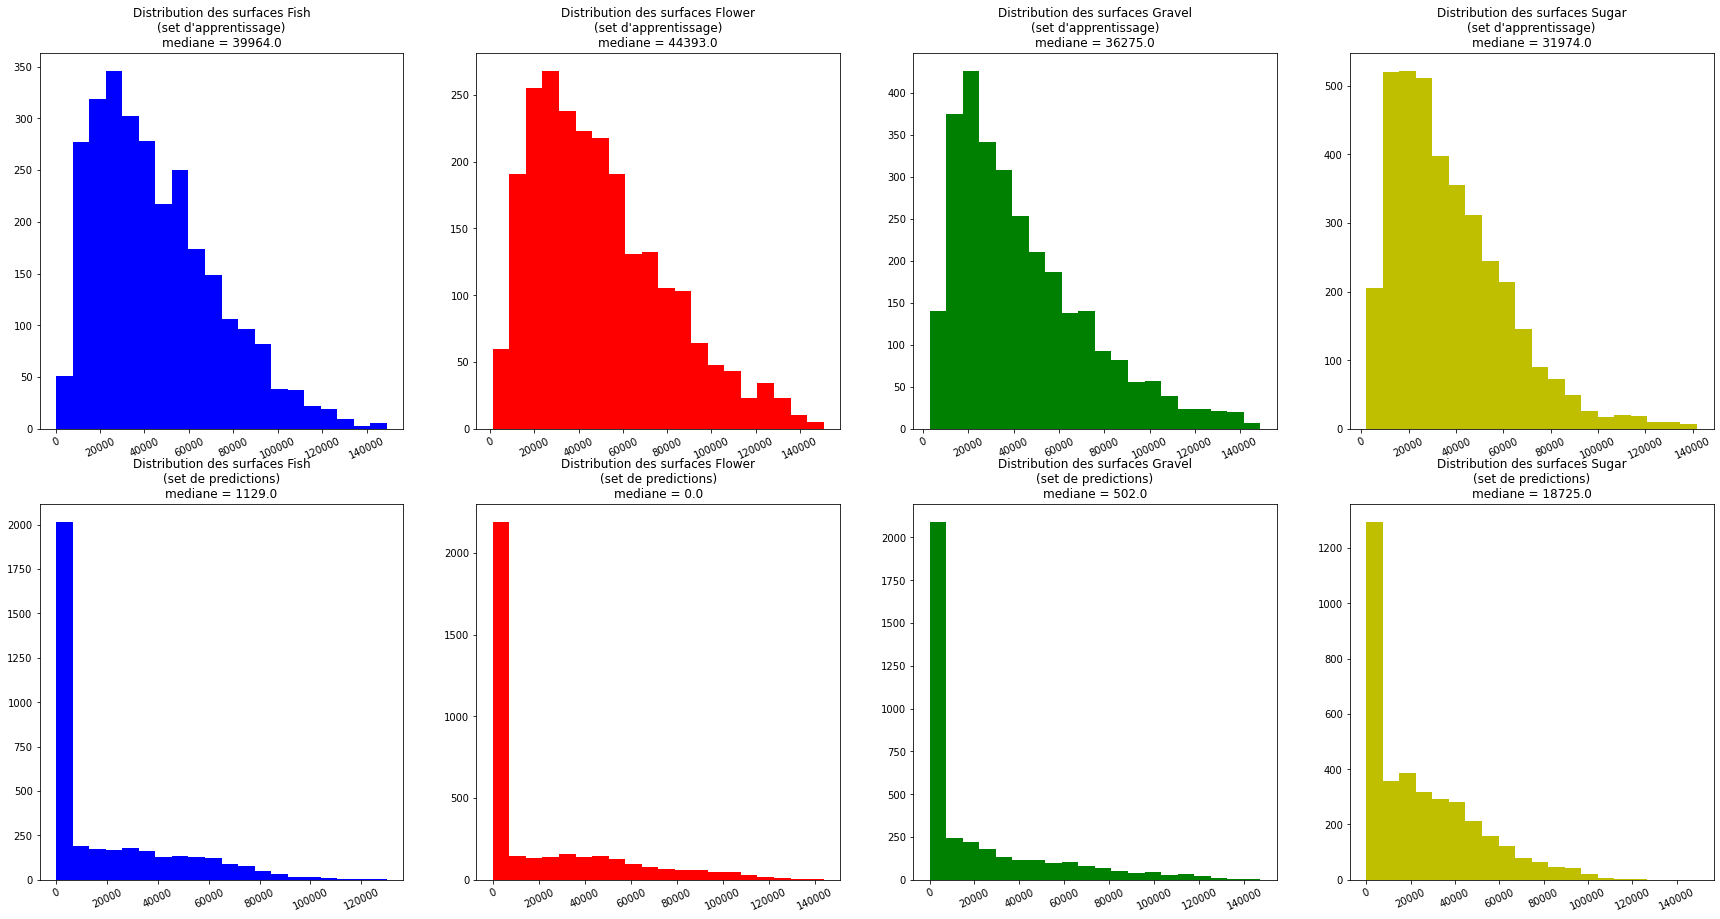

In [ ]:
def get_surfaces(classe, facteur):
    surfaces = []

    for rle in train_transformed[classe]:
        if not isinstance(rle, float):
            surfaces.append(packages.surfaceFromRle(rle) / facteur)

    return surfaces

facteur = (origin_size[0] * origin_size[1]) / (target_size[0] * target_size[1])
surfaces = []
surfaces.append(get_surfaces('Fish', facteur))
surfaces.append(get_surfaces('Flower', facteur))
surfaces.append(get_surfaces('Gravel', facteur))
surfaces.append(get_surfaces('Sugar', facteur))
histcolors=['b', 'r', 'g', 'y']

fig, ax = plt.subplots(figsize=(30, 65))

for i in range(len(formations_nuageuses)):
    plt.subplot(8,4,i+1)
    plt.hist(surfaces[i], bins=20, color=histcolors[i])
    plt.title("Distribution des surfaces " + formations_nuageuses[i] + "\n(set d'apprentissage)\nmediane = " + str(round(np.median(surfaces[i]),0)))
    plt.xticks(rotation = 25)

surfaces_predites = [None] * len(formations_nuageuses)
for classe in range(len(formations_nuageuses)):
    surfaces_predites[classe] = []
    for lot in sub_pred:             #pour chaque lot ...

        for i in range(len(lot)):    #... et chaque image

            #On récupère les masques prédits pour l'ensemble des classes
            pred_masks = lot[i, ]
            seuil = maskSeuils[classe]
            pred_mask = cv2.threshold(pred_masks[ :, :, classe], seuil, 1, cv2.THRESH_BINARY)[1]
            surfaces_predites[classe].append(pred_mask.sum())

for i in range(len(formations_nuageuses)):
    plt.subplot(8,4,i+5)
    plt.hist(surfaces_predites[i], bins=20, color=histcolors[i])
    plt.title("Distribution des surfaces " + formations_nuageuses[i] + "\n(set de predictions)\nmediane = " + str(round(np.median(surfaces_predites[i]),0)))
    plt.xticks(rotation = 25)

plt.show()



Nous pouvons constater que sur le set de prédiction, dans les valeurs faibles de surface il y a un nombre très important de petites surfaces. Pour les trois premières classes, ceci ramène la médiane à 0. Ces petites surfaces vont nuire à la performance du modèle, il nous faut les filtrer.

Ci-dessous un bon exemple de petites surfaces prédites. On peut en effet apercevoir des prédictions de formation nuageuse « Sucre » en jaune couvrant des surfaces relativement limitées.

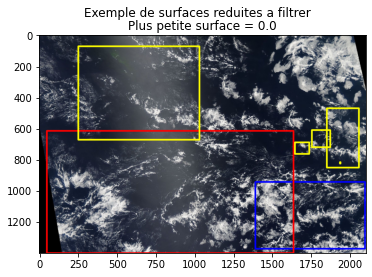

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("Exemple de surfaces réduites à filtrer", fontsize=12)
im1 = plt.imread(os.path.join(repTest, sub_imgs[3]))
lot = sub_pred[0]

surface_min = -1
for k in range(4):
    pred_masks1 = cv2.threshold(lot[30, :, :, k], maskSeuils[k], 1, cv2.THRESH_BINARY)[1]
    packages.trace_boundingBox(im1, packages.np_transposition(pred_masks1, origin_size), color=couleurs[k])
    if surface_min < 0 or pred_masks1.sum() < surface_min:
        surface_min = pred_masks1.sum()

ax.imshow(im1)  
ax.set_title("Plus petite surface = " + str(surface_min))
plt.show()

Pour filtrer ces prédictions "parasites" nous établissons tout d'abord, sur la base du set d'apprentissage, les percentiles des surfaces propres à chaque classe. Nous retenons au final arbitrairement le 15e percentile. Ainsi lors du post-traitement des prédictions, toutes les surfaces inférieures à ces valeurs seront supprimées.

In [32]:
def get_percentiles(classe, facteur):
    surfaces = []

    for rle in train_transformed[classe]:
        if not isinstance(rle, float):
            surfaces.append(packages.surfaceFromRle(rle))

    return np.percentile(np.array(surfaces), [15, 50, 90]) / facteur

facteur = (origin_size[0] * origin_size[1]) / (target_size[0] * target_size[1])

percentiles = []
percentiles.append(get_percentiles('Fish', facteur))
percentiles.append(get_percentiles('Flower', facteur))
percentiles.append(get_percentiles('Gravel', facteur))
percentiles.append(get_percentiles('Sugar', facteur))

for indice, classe in enumerate(formations_nuageuses):
    print('15e percentile ', classe, ' : ', int(percentiles[indice][0]))


15e percentile  Fish  :  17385
15e percentile  Flower  :  19068
15e percentile  Gravel  :  15993
15e percentile  Sugar  :  14297


#### **7.2.4 - Post-traitements**

Nous synthétisons dans cette partie les différents retraitements détaillés précédemment pour modifier les masques de prédictions en conséquence.

In [33]:
def postTraitements(pred_mask, seuil, surface):

    #Activation des pixels sur la base d'un seuil spécifique
    pred_mask = cv2.threshold(pred_mask, seuil, 1, cv2.THRESH_BINARY)[1]

    #on vérifie la superficie qui en résulte ...
    # ... la taille minimale est atteinte, on retient ce masque
    if pred_mask.sum() >= surface:
        return pred_mask
    
    # ... la taille minimale n'est pas atteinte, on fait un reset du masque
    return  np.zeros(pred_mask.shape, np.float32) 

In [34]:
#Pour chacun des lots on génère les encodage RLE associés aux prédictions
#Il faut bien faire attention de spécifier la taille de masque attendue par Kaggle

sub_rles = []

for lot in sub_pred:             #pour chaque lot ...
    for i in range(len(lot)):    #... et chaque image

        #On récupère les masques prédits pour l'ensemble des classes
        pred_masks = lot[i, ]

        #Pour chaque classe ...
        for classe in range(len(formations_nuageuses)):

            #On récupère le seuil associé
            seuil = maskSeuils[classe]

            #ainsi que la surface minimum voulue
            surface = percentiles[classe][0] 

            #Traitement du masque
            pred_masks[ :, :, classe] = postTraitements(pred_masks[ :, :, classe], seuil, surface)

        #Le traitement complémentaire étant terminé, on convertit les masques en code RLE
        pred_rles = packages.list_maskToRle(pred_masks, reshape=submission_mask_size)
        sub_rles.append(pred_rles)


### **7.3 - Constitution du fichier de soumission Kaggle**

Pour finir, il nous suffit de compléter le dataframe de soumission, initialement créé, avec les prédictions. Le tout est exporté dans un fichier CSV au format attendu par Kaggle puis compressé.

In [35]:
#Mise à jour du dataframe de soumission avec les prédictions
row = 0
for prediction in sub_rles:
    for i in range(len(formations_nuageuses)):
        df_sub.EncodedPixels[row] = prediction[i]
        row += 1

In [36]:
#Mise en forme et sauvegarde du fichier de soumission Kaggle
output_filename = 'nubela' 
final_sub = df_sub.drop(['image'], axis = 1)
final_sub.to_csv(output_filename + '.csv', index=False)

#Compression du fichier de sortie
#Le site de la compétition Kaggle préconise un upload au format zip pour
#gagner en temps de traitement
zip_file = zipfile.ZipFile(output_filename + '.zip', 'w')
zip_file.write(output_filename + '.csv', compress_type=zipfile.ZIP_DEFLATED)
zip_file.close()

### **7.4 - Scores Kaggle**

L'ensemble tel qu'il a été présenté dans ce notebook obtient sur Kaggle les scores ci-dessous :
-	Score privé = 0.66016 (position 74)
-	Score public = 0.66173

Pour rappel, le score public est établi sur 25% des données de test, le score privé, sur les 75% restant. Le score comptant au final dans le classement est le score privé.<br>
On peut penser que l'ensemble de modèles est relativement performant dans la mesure ou les backbones choisis comptent un nombre relativement restreint de paramètres.<br>



## **8 - Prédictions ponctuelles**

### **8.1 - Prédictions sur la base d'un set de test**

Nous allons effectuer des prédictions via le modèle 1 sur la base d'un lot test dans le seul but de visualiser en parallèles les masques associés aux prédictions brutes puis ceux associés aux prédictions post-traitées.

Nous utilisons le set de test de 224 images mis de côté précédemment puis nous instancions un générateur sur celles-ci.<br>
Enfin nous lançons la prédiction via le modèle 1 uniquement.


In [ ]:
batchSize = 32
test_imgs = test_collector.tolist()

#Instanciation d'un générateur
test_generator = MultiGenerator(test_imgs,
                              batch_size=batchSize, 
                              reshape=target_size,
                              augment=False,
                              shuffle=False,
                              nb_canaux=nb_canaux,
                              nb_classes=nb_classes)

#Prédictions via le premier modèle
prediction_masks1 = model1.predict(test_generator, workers=1, verbose=1)

7/7 [==============================] - 11s 1s/step


Les prédictions brutes ayant été générées, nous effectuons le post-traitement dans une structure dédiée pour conserver les prédictions brutes intactes.

In [ ]:
#Post-traitement des prédictions

#prediction_masks_processed = prediction_masks
prediction_masks_processed = np.copy(prediction_masks1)
       
for i in range(len(prediction_masks_processed)):    # pour chaque image

    #Pour chaque classe ...
    for classe in range(len(formations_nuageuses)):

        #On récupère le seuil associé
        seuil = maskSeuils[classe]

        #ainsi que la surface minimum voulue
        surface = percentiles[classe][0] 

        #Traitement du masque
        prediction_masks_processed[i, :, :, classe] = postTraitements(prediction_masks_processed[i, :, :, classe], seuil, surface)

Enfin nous affichons quelques images au hasard afin de présenter pour chacune les zones d'origine, les zones prédites brutes, puis les zones prédites retraitées.

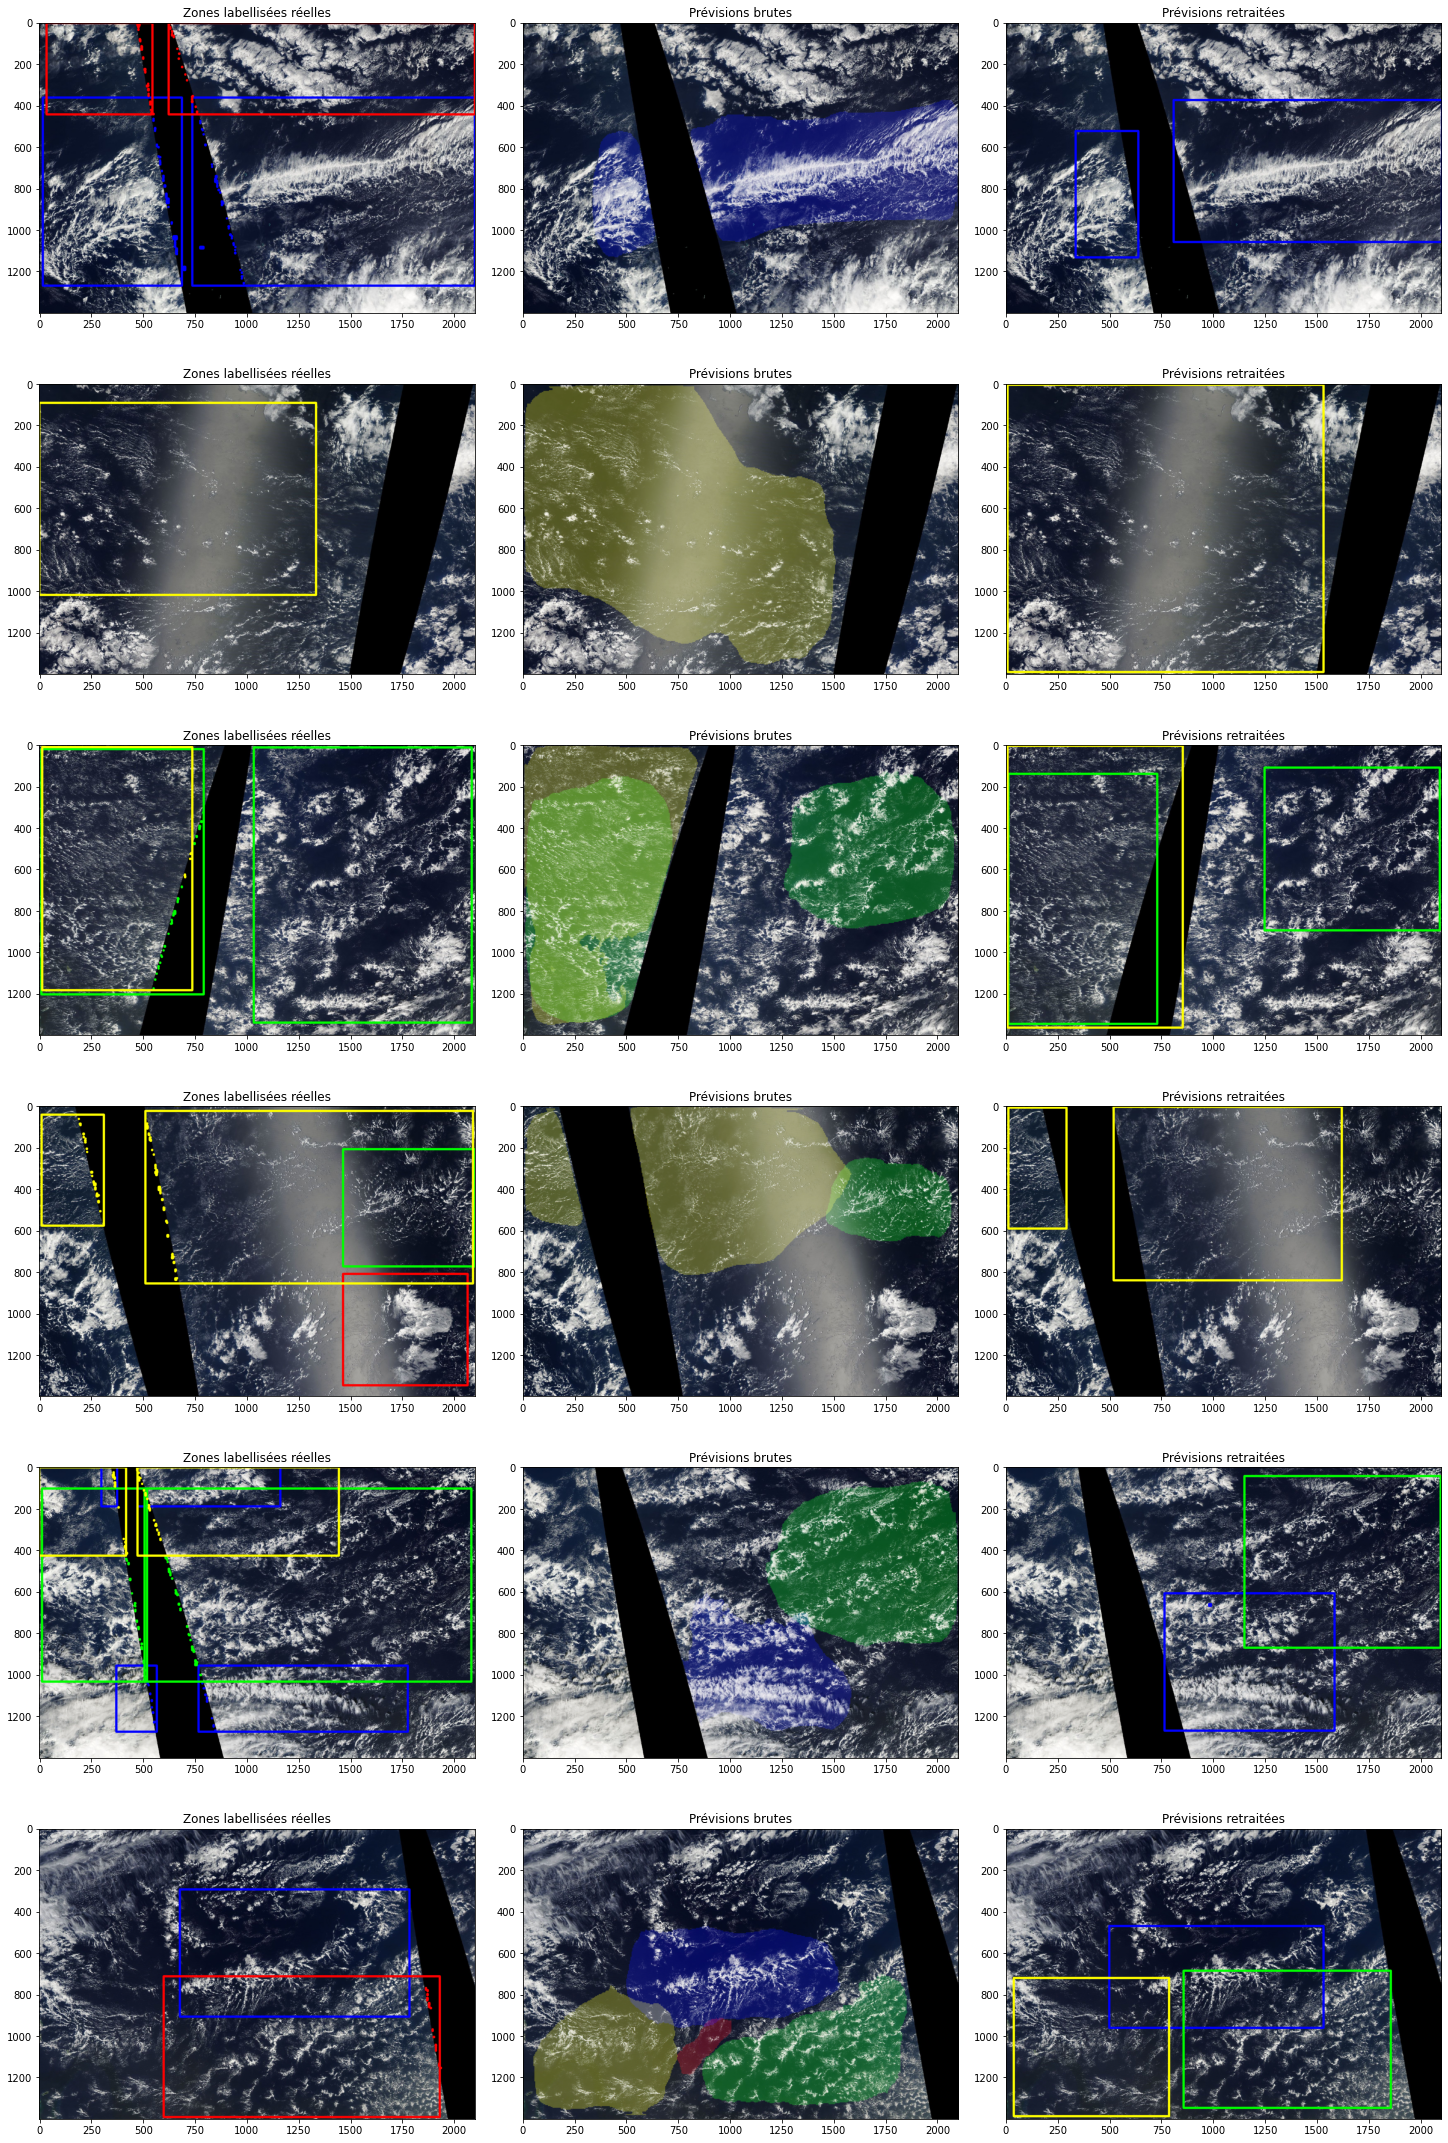

In [ ]:
#Confusion des prédictions et des données réelles

fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20, 30), constrained_layout=True)

nb_images = 6
j= 0
for i in random.sample(list(np.arange(0,test_size)), nb_images):

    pred_masks = prediction_masks1[i, ].round().astype(int)
    pred_rles = packages.list_maskToRle(pred_masks, reshape=origin_size)

    pred_masks_processed = prediction_masks_processed[i, ].round().astype(int)
    pred_rles_processed = packages.list_maskToRle(pred_masks_processed, reshape=origin_size)


    im = plt.imread(os.path.join(repTrain, test_imgs[i]))
    for indice, rle in enumerate(index_classes[test_imgs[i]]) :
        if not isinstance(rle, float):
            mask = packages.rleToMask(rle, origin_size)
            packages.trace_boundingBox(im, mask, color=couleurs[indice]) 
    ax[j,0].imshow(im) 
    ax[j,0].set_title("Zones labellisées réelles")   


    im2 = plt.imread(os.path.join(repTrain, test_imgs[i]))
    ax[j,1].set_title("Prévisions brutes")        
    for k in range(4):
        mask = packages.rleToMask(pred_rles[k], origin_size)
        im2 = packages.maskInColor(im2, mask, color=couleurs[k], alpha=0.3)
    ax[j,1].imshow(im2)  

    im3 = plt.imread(os.path.join(repTrain, test_imgs[i]))
   
    for k in range(4):
        mask = packages.rleToMask(pred_rles_processed[k], origin_size)
        packages.trace_boundingBox(im3, mask, color=couleurs[k])

    ax[j,2].imshow(im3) 
    ax[j,2].set_title("Prévisions retraitées") 
    
    j+=1
    
plt.show()

### **8.2 - Prédictions d'image issues du module NASA earthdata**

Le module EartView de la NASA offre la possibilité de charger des images satellite, pour un jour donné et au-dessus d'une zone donnée. Pour illustrer la capacité du modèle à identifier les formations nuageuses sur des images inconnues, nous soumettons ici une requête au module earthData afin de télécharger une image satellite prise au-dessus des caraïbes le 26/12/2019.

Sur la base de la prédiction effectuée par notre modèle sur cette image nous colorons ensuite les formations nuageuses identifiées.


In [18]:
#Récupération d'une photo satellite depuis l'appli worldview de la NASA
def get_earthdataView(image_date, image_heure, target_size):
    url = "https://wvs.earthdata.nasa.gov/api/v1/snapshot?REQUEST=GetSnapshot&TIME="+image_date+"T"+image_heure+"Z&BBOX=13.539855936494165,-46.89858946849988,25.854208633627493,-28.44241497728509&CRS=EPSG:4326&LAYERS=MODIS_Aqua_CorrectedReflectance_TrueColor,Coastlines_15m&WRAP=day,x&FORMAT=image/jpeg&WIDTH=2100&HEIGHT=1400&ts=1619077410459"
    im = Image.open(requests.get(url, stream=True).raw)
    im = im.resize((target_size[1], target_size[0]), Image.ANTIALIAS)  
    return im


1/1 [==============================] - 6s 6s/step


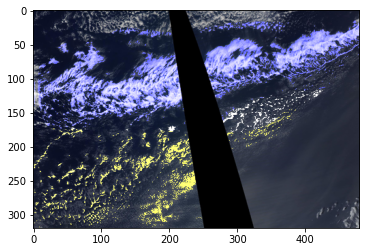

In [19]:
#Définition de la date et de l'heure voulues
image_date = '2019-02-26'
image_heure = '08:00:00'

#Récupération de l'image
im = get_earthdataView(image_date, image_heure, target_size)

#Conversion en tensor
im_tensor = packages.imageToTensor(im)

#Prédictions
preds_nasa= model1.predict(im_tensor, verbose=1)

do_postTraitement = True

if do_postTraitement:
    #Post-traitement des prédictions
    for i in range(len(preds_nasa)):    

        #Pour chaque classe ...
        for classe in range(len(formations_nuageuses)):

            #On récupère le seuil associé
            seuil = maskSeuils[classe]

            #ainsi que la surface minimum voulue
            surface = percentiles[classe][0] 

            #Traitement du masque
            preds_nasa[i, :, :, classe] = postTraitements(preds_nasa[i, :, :, classe], seuil, surface)

preds_nasa_masks = preds_nasa[0, ].round().astype(int)

fig, ax = plt.subplots()
im3 = np.array(im)

for k in range(4):
    mask = (preds_nasa_masks[:,:,k]).astype(np.uint8)
    im3 = packages.cloudInColor(im3, mask, color=couleurs[k], alpha=0.7, threshold=90)

ax.imshow(im3) 
plt.show()
